In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
# loading base image
base_image_path = 'images/yl.jpg'
base_image = tf.keras.preprocessing.image.load_img(base_image_path)

# loading style image
style_image_path = 'images/street.jpg'
style_image = tf.keras.preprocessing.image.load_img(style_image_path)

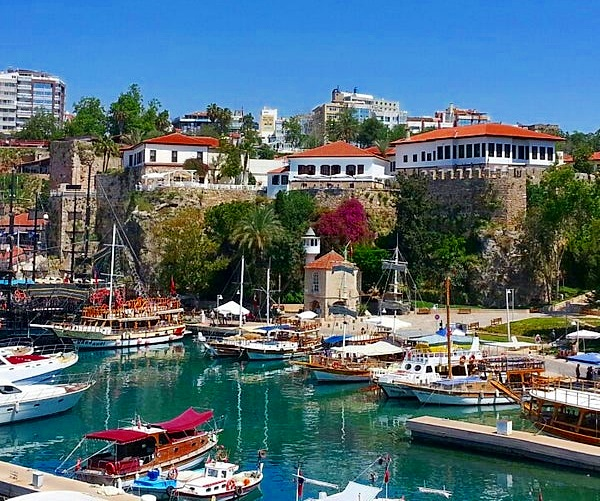

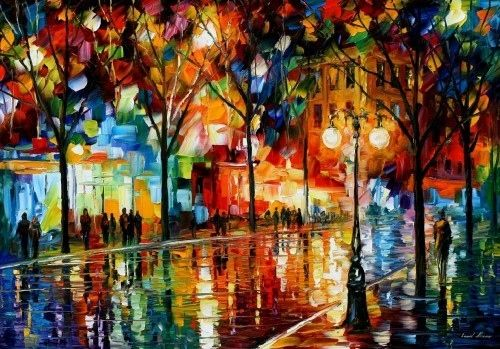

In [ ]:
# display images
from IPython.display import Image, display

display(base_image)
display(style_image)

In [ ]:
# weights of the loss components
variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [ ]:
# setting the dimensions of the generated picture
width, height = base_image.size
img_nrows = 400
# protecting aspect ratio
img_ncols = int(width * (img_nrows / height))

In [ ]:
# Image preprocessing / deprocessing utilities

def preprocess_image(image_path):
    """
    Preprocesses image for EfficientNetB1
    """
    img = tf.keras.preprocessing.image.load_img(image_path,
                                                target_size=(img_nrows, img_ncols))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)

    return tf.convert_to_tensor(img)

def deprocess_image(tensor):
    """
    Converts tensor to image

    Since preprocess_input from EfficientNetB1 is just a pass through function,
    we don't need to do anything special here
    """
    tensor = tensor.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    tensor[:, :, 0] += 103.939
    tensor[:, :, 1] += 116.779
    tensor[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    tensor = tensor[:, :, ::-1]
    tensor = np.clip(tensor, 0.0, 255.0).astype('uint8')

    return tensor

In [ ]:
# Util function to compute the style transfer loss

def gram_matrix(tensor):
    """
    Computes the Gram matrix of the input tensor
    """
    # (h, w, c) -> (c, h, w)
    tensor = tf.transpose(tensor, (2, 0, 1))
    # (c, h, w) -> (c, h * w)
    features = tf.reshape(tensor, (tf.shape(tensor)[0], -1))
    # (c, h * w) x (h * w, c) -> (c, c)
    gram = tf.matmul(features, tf.transpose(features))

    return gram

def style_loss(style, combination):
    """
    Computes the style loss
    """
    # gram matrices
    S = gram_matrix(style)
    C = gram_matrix(combination)

    # channels and size
    channels = 3
    size = img_nrows * img_ncols

    # calculating the style loss
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    """
    Computes the content loss
    """
    # calculating the content loss
    return tf.reduce_sum(tf.square(combination - base))

def total_variation_loss(tensor):
    """
    The function calculates the components of the total variation loss.
    It calculates the squared differences between neighboring pixels in the
    horizontal and vertical directions.
    These differences are calculated for each color channel of the input tensor.
    """

    # The tensor a represents the squared differences between pixels in adjacent rows
    #, except for the last row.
    a = tf.square(
        tensor[:, :img_nrows - 1, :img_ncols - 1, :] - tensor[:, 1:, :img_ncols - 1, :])

    # The tensor b represents the squared differences between pixels in adjacent columns
    #, except for the last column.
    b = tf.square(
        tensor[:, :img_nrows - 1, :img_ncols - 1, :] - tensor[:, :img_nrows - 1, 1:, :])

    # This line computes the actual total variation loss by summing up the powered
    #added tensors a and b
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
# building the model

model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# getting the outputs of intermediate layers
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# setting up a model that returns the activation values for every layer in
# EfficientNetB1 given an input image
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
# choosing the layers that will be used for content and style loss
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layer = "block5_conv2"

# computing the loss

def compute_loss(combination_image, base_image, style_reference_image):
    """
     This function calculates the total loss for a neural style transfer optimization.
     It combines content loss, style loss, and total variation loss to form a single
    loss value that guides the optimization process.
    """
    # concatenating the base image, style image and combination image
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    # getting the outputs of intermediate layers
    features = feature_extractor(input_tensor)

    # initializing the loss
    loss = tf.zeros(shape=())

    # adding the content loss
    layer_features = features[content_layer]

    # base image features are the first features
    base_image_features = layer_features[0, :, :, :]
    # combination image features are the third features
    combination_features = layer_features[2, :, :, :]

    # calculating the content loss
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )

    # adding the style loss
    for layer_name in style_layers:
        # getting the style features
        layer_features = features[layer_name]

        # style reference features are the second features
        style_reference_features = layer_features[1, :, :, :]
        # combination features are the third features
        combination_features = layer_features[2, :, :, :]

        # calculating the style loss
        sl = style_loss(style_reference_features, combination_features)
        # adding the style loss
        loss += (style_weight / len(style_layers)) * sl

    # adding the total variation loss
    loss += variation_weight * total_variation_loss(combination_image)

    return loss


In [ ]:
# loss and gradient computation

# making the function a callable graph via tf.function decorator
# in order to speed up the execution

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    # using GradientTape to update the gradients
    with tf.GradientTape() as tape:
        # calculating the loss
        loss = compute_loss(combination_image, base_image, style_reference_image)
    # calculating the gradients
    grads = tape.gradient(loss, combination_image)

    return loss, grads

In [ ]:
# the style transfer loop

# defining Adam optimizer with exponential learning rate decay of 0.9
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=200.0, decay_steps=100, decay_rate=0.96
    )
)

# preparing the base image
base_image = preprocess_image(base_image_path)
# preparing the style image
style_reference_image = preprocess_image(style_image_path)
# initializing the combination image as a tensor version of base image
combination_image = tf.Variable(preprocess_image(base_image_path))

# number of iterations
iterations = 1000

# type of the style image
OUT = "results"
STYLE = "street"
BASE = "yl"

for i in range(1, iterations+1):
    # computing the loss and gradients
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    # applying the gradients to the combination image
    optimizer.apply_gradients([(grads, combination_image)])

    if i % 10 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")

# saving the current combination image
img = deprocess_image(combination_image.numpy())
fname = f"images/{OUT}/{BASE}_plus_{STYLE}.png"
tf.keras.preprocessing.image.save_img(fname, img)

Iteration 10: loss=29138.88
Iteration 20: loss=14170.38
Iteration 30: loss=10331.08
Iteration 40: loss=9156.29
Iteration 50: loss=11290.57
Iteration 60: loss=7300.37
Iteration 70: loss=6272.85
Iteration 80: loss=6105.56
Iteration 90: loss=5745.05
Iteration 100: loss=5644.13
Iteration 110: loss=8650.56
Iteration 120: loss=6612.47
Iteration 130: loss=6250.57
Iteration 140: loss=4813.16
Iteration 150: loss=4756.92
Iteration 160: loss=4602.99
Iteration 170: loss=4574.35
Iteration 180: loss=4371.63
Iteration 190: loss=4712.87
Iteration 200: loss=4249.17
Iteration 210: loss=4180.20
Iteration 220: loss=4374.16
Iteration 230: loss=4547.75
Iteration 240: loss=3816.88
Iteration 250: loss=3758.58
Iteration 260: loss=4428.12
Iteration 270: loss=3912.65
Iteration 280: loss=4672.07
Iteration 290: loss=3642.56
Iteration 300: loss=3649.92
Iteration 310: loss=3628.24
Iteration 320: loss=3883.37
Iteration 330: loss=3736.35
Iteration 340: loss=3521.10
Iteration 350: loss=3413.03
Iteration 360: loss=3643.

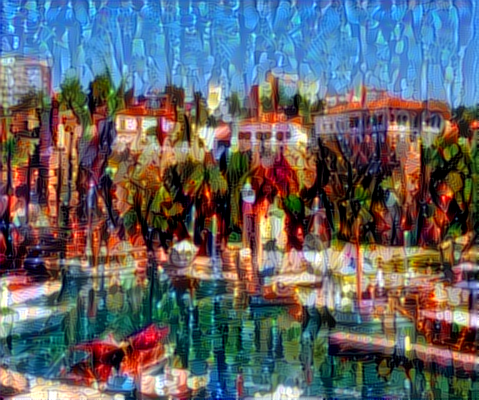

In [ ]:
display(Image(f"images/{OUT}/{BASE}_plus_{STYLE}.png"))